# First tests with Fourier Domain Adaptation

## Requirements

In [3]:
import os
import sys
import json
import random
from pathlib import Path
sys.path.insert(0, os.path.join("..", "..", "src"))

import torch
import pyvips
import deeplake
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

'''from utils.constants import (
    RAW_DIR, 
    PATCH_DIR,
    ASSET_DIR,
    SEVERITY_COLOR_MAP
)'''

'''from utils import (
    img_transform_fn
)'''

'from utils import (\n    img_transform_fn\n)'

## Verification of the dataset

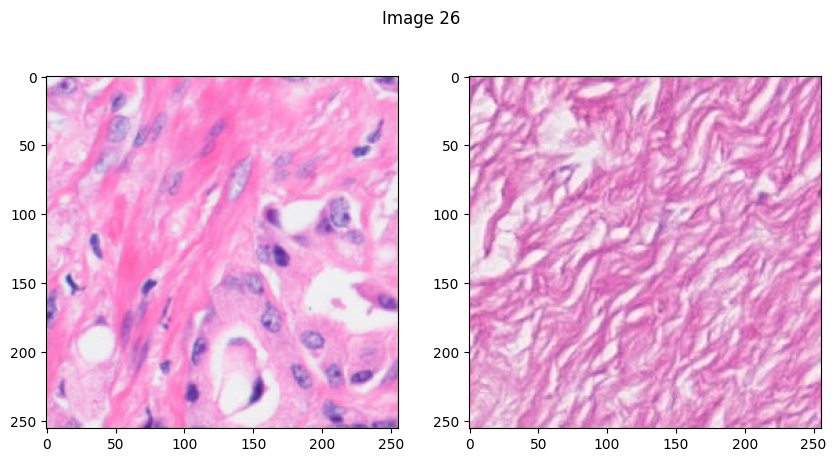

In [7]:
import time
from IPython.display import clear_output
#test automatique du bon fonctionnement du dataset
for i in range(1,25+1):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    dataset_path = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_Akoya"
    ds = deeplake.open_read_only(dataset_path)
    axes[0].imshow(ds[200]["patch"])
    #plt.show()
    dataset_path = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_{i}_KFBio"
    ds = deeplake.open_read_only(dataset_path)
    axes[1].imshow(ds[200]["patch"])
    plt.suptitle(f"Image {i+1}")
    plt.show()
    time.sleep(4)
    clear_output(wait=True)

## Visualisation of Akoya and unmodified KFBio

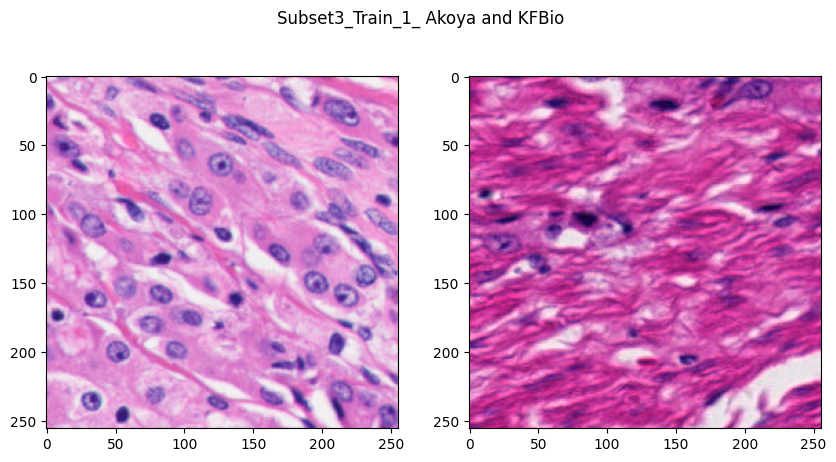

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
dataset_path = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_Akoya"
ds = deeplake.open_read_only(dataset_path)
axes[0].imshow(ds[200]["patch"])
#plt.show()
dataset_path = f"/home/leolr-int/data/data/patched/dim_256/Train/Subset3_Train_1_KFBio"
ds = deeplake.open_read_only(dataset_path)
axes[1].imshow(ds[200]["patch"])
plt.suptitle(f"Subset3_Train_1_ Akoya and KFBio")
plt.show()


We can see that KFBio is much darker than Akoya, which resulted in worse performances.

## Global Fourier Domain Adaptation
Inspired from Yanchao Yang & Stefano Soatto 2020, git available at https://github.com/YanchaoYang/FDA.git

### Pairwise migration

Here, we try to make one KFBio image closer from one reference Akoya image using Fourier analysis.

In [ ]:
print(type(ds[200]["patch"])) #<type 'numpy.ndarray'>

def extract_ampl_phase(fft_im):
    # fft_im: size should be bx3xhxwx2
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    fft_amp = torch.sqrt(fft_amp)
    fft_pha = torch.atan2( fft_im[:,:,:,:,1], fft_im[:,:,:,:,0] )
    return fft_amp, fft_pha

def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def FDA_source_to_target_np( src_img, trg_img, L=0.1 ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg

<class 'numpy.ndarray'>
